# Prevendo a Cotação de Criptomoedas em Tempo Real com PySpark e Machine Learning

* Dataset: https://bitcoincharts.com/charts/
* Usado a API Pyspark devido ao volume do dataset utilizando todo o histórico do ativo bitcoin

In [2]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [3]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [4]:
# Imports python
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# Imports Spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Henrique Bardella" --iversions

Author: Henrique Bardella

pyspark   : 3.3.0
sys       : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.5.0
numpy     : 1.21.5
matplotlib: 3.5.1
findspark : 2.0.1
seaborn   : 0.11.2



# Preparando o ambiente Spark

In [8]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [9]:
# Criando o Spark Context
sc = SparkContext(appName = "Projeto3-Previsao_cotacao_criptomoedas")

In [10]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [11]:
# Visualiza o objeto spark_session
spark_session

# Carregando os dados

In [12]:
# Carrega os dados a partir da sessão spark
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'True', inferSchema = 'True')

In [13]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# Visualiza os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [15]:
# Visualiza os metadados (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [16]:
# Verifica o número de linhas
df_spark.count()

4856600

# Data Wrangling com SparkSQL

In [17]:
# Cria uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin') 

In [18]:
# Executa uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [19]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [20]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [21]:
# Remove valores NA (não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [22]:
# Número de registros
df_bitcoin.count()

3613769

In [23]:
# Vamos renomear algumas colunas para facilitar a manipulação dos dados
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [24]:
# Visualiza
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

In [25]:
# Visualiza os metadados (schema)
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



> A coluna dateTime fornece os detalhes da data da cotação. Vamos separar os elementos da data em diferentes colunas.

In [26]:
# Vamos dividir o dataframe extraindo data
df_data = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [27]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [28]:
# Vamos dividir o dataframe extraindo tempo
df_data = df_data.withColumn("time", split(col("dateTime")," ").getItem(1))

In [29]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [30]:
# Visualiza os dados
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [31]:
# Vamos dividir o dataframe extraindo a hora
df_data_hora = df_data.withColumn("hour", split(col("time"),":").getItem(0))

In [33]:
# Vamos ajustar o formato da data para extrair o dia da semana
# metodo cast transforma o tipo de dado
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))

In [34]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [40]:
# Vamos extrair o dia da semana
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [41]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [42]:
# Vamos extrair o ano da cotação
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"),"-").getItem(0))

In [43]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [44]:
# Converte o dataframe do Spark para o Pandas - Para facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [45]:
type(df_pandas)

pandas.core.frame.DataFrame

In [46]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

In [48]:
df_pandas

,Timestamp,Open,High,Low,Close,VolBTC,VolCurrency,Weighted_Price,dateTime,date,time,hour,day_of_week,year
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011-12-31,05:52:00,5.0,7,2011
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011-12-31,13:50:00,13.0,7,2011
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31,2011-12-31,14:59:00,14.0,7,2011
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011-12-31,15:00:00,15.0,7,2011
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012-01-01,02:16:00,2.0,1,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613764,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30,2021-03-30,20:56:00,20.0,3,2021
3613765,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30,2021-03-30,20:57:00,20.0,3,2021
3613766,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30,2021-03-30,20:58:00,20.0,3,2021
3613767,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30,2021-03-30,20:59:00,20.0,3,2021


# Análise exploratória

C:\Users\henri\AppData\Local\Temp\ipykernel_26540\260144388.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pandas.corr()


<AxesSubplot:>

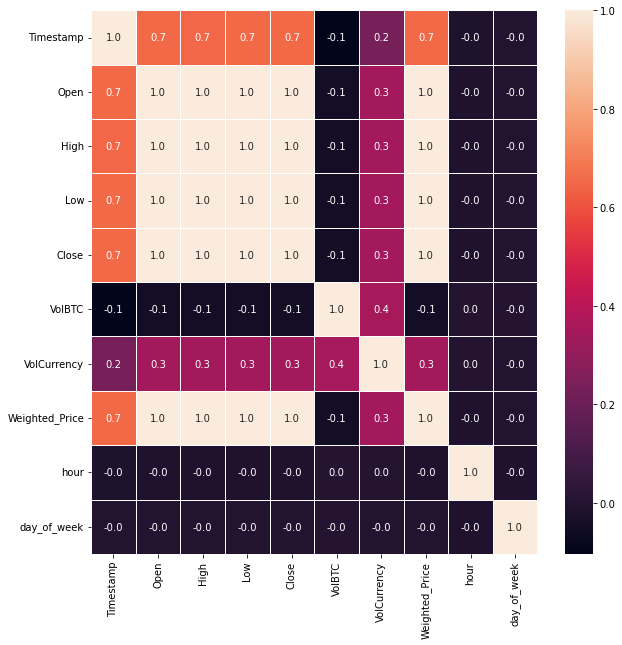

In [47]:
# Heatmap para visualiar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

> Idealmente queremos alta correlação entre as variáveis de entrada e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

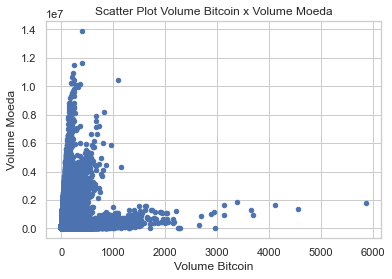

In [49]:
# Scatter plot volume bitcoin x volume moeda
plt.figure(figsize = (12, 5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

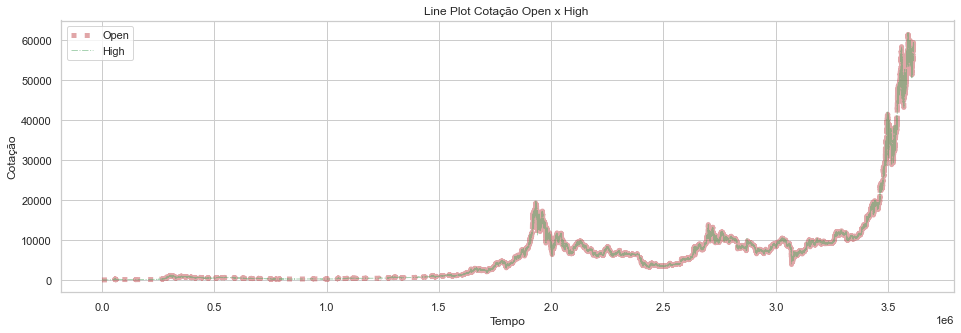

In [50]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

> Alta correlação entre Open e High (multicolinearidade), uma delas tem que sair para não deixar o modelo tendencioso.

<AxesSubplot:ylabel='Frequency'>

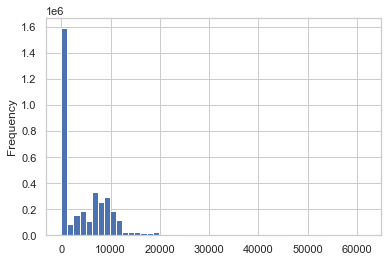

In [51]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

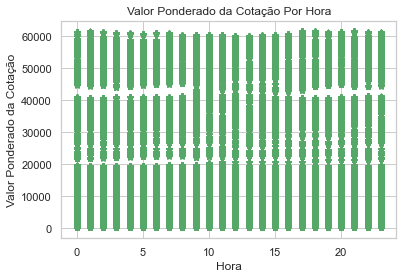

In [52]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

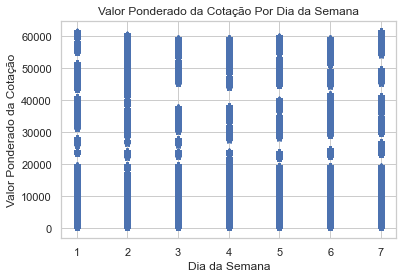

In [53]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

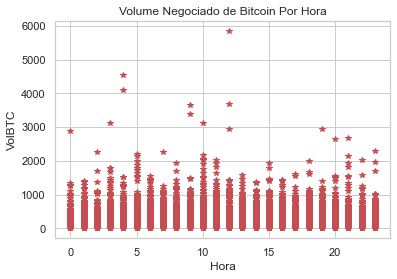

In [54]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

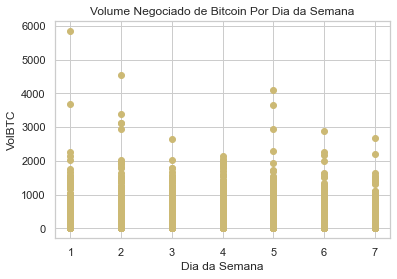

In [55]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

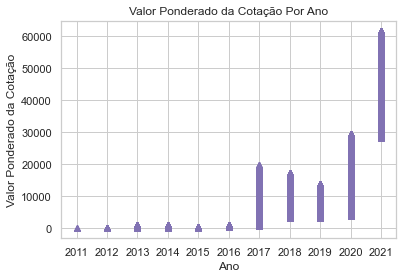

In [56]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

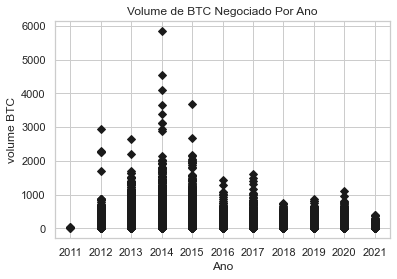

In [57]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

## Engenharia de Atributos com PySpark

In [58]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [59]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'], 
                            outputCol = "features")

> O apache spark necessita o vetor de atributos para o modelo de ML.

In [60]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [61]:
# Visualiza os dados
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


### Normalização

In [63]:
# Divisão em dados de treino e teste
dados_treino, dados_teste = df_assembled.randomSplit([.7, .3], seed = rnd_seed)

In [64]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [65]:
# Cria o scaler (objeto responsável pela normalização dos dados)
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [66]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [68]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [78]:
# Fit e transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [79]:
dados_treino_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,0.45558087,2.0000000193] |[9.553145931914242E-6,7.782582427582654E-5,1.4387793343672024E-7]  |
|[4.58,1.502,6.87916]           |[1.2629582757445955E-5,2.5658317932070207E-4,4.948796575146856E-7] |
|[5.0,19.048,95.24]             |[1.9430127319147618E-5,0.0032539256988686634,6.8514671241399605E-6]|
|[5.32,2.41917293,12.869999988] |[2.4611494604253653E-5,4.132617055299456E-4,9.258544918675314E-7]  |
|[5.29,29.30245747,155.01000002]|[2.4125741421274957E-5,0.005005670905167947,1.1151259124842134E-5] |
|[5.29,11.28544423,59.699999977]|[2.4125741421274957E-5,0.0019278662853394624,4.2947562699871055E-6]|
|[5.19,2.6416185,13.710000015]  |[2.250656414467933E-5,4.5126156676590146E-4,9.862

In [80]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

### Machine Learning

> Versão 1 do modelo (benchmark)

In [81]:
# Cria o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = 'scaled_features',
                                labelCol = 'Weighted_Price',
                                 predictionCol = 'Predicted_price',
                                 maxIter = 100,
                                 regParam = 0.3,
                                 elasticNetParam = 0.8,
                                 standardization = False))

In [82]:
# Treina o modelo 
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

In [83]:
# Salva o modelo em disco
modelo_v1.write().overwrite().save("modelos/modelo_v1")

### Avaliação do modelo

In [84]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [87]:
# Seleciona as colunas
pred_data_v1 = previsoes_v1.select("Predicted_price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 7.479804979937391|          4.39|
|7.6697042508838695|          4.58|
| 8.089481586660293|           5.0|
| 8.409311937728045|          5.32|
| 8.379327842315442|          5.29|
| 8.379327842315442|          5.29|
| 8.279380857606771|          5.19|
| 8.449290731611514|  5.3604618117|
| 8.839083971975334|   5.777027027|
| 9.088951433747017|           6.0|
+------------------+--------------+
only showing top 10 rows



In [88]:
# Mean Absolute Error
print(" Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

 Mean Absolute Error (MAE) nos dados de teste: 5.035217775680379


In [89]:
# Cria um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [90]:
# Aplica o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste = 11.3438


In [91]:
# Extrai as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)

In [92]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

Exception ignored in: <function JavaWrapper.__del__ at 0x00000199A0C831F0>
Traceback (most recent call last):
  File "C:\Users\henri\anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LinearRegression' object has no attribute '_java_obj'


In [93]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

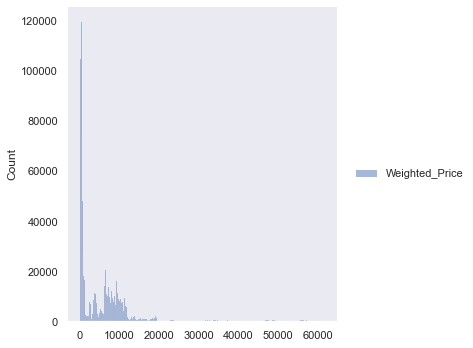

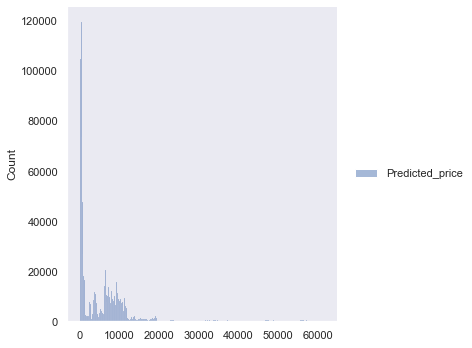

In [94]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

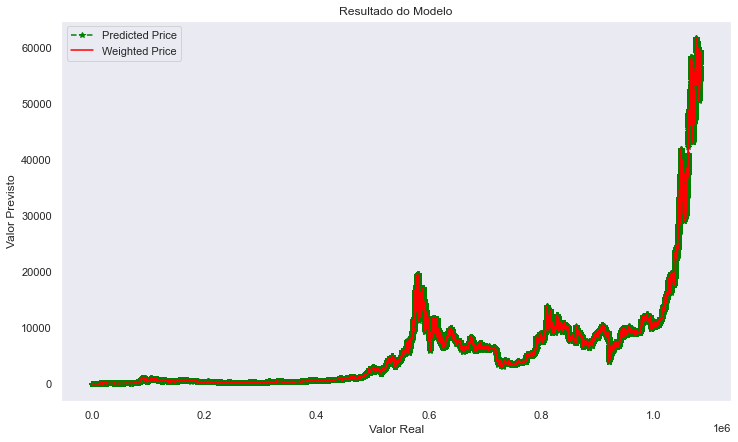

In [95]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

> Versão 2 do Modelo (Otimização de Hiperparâmetros)

In [96]:
# Cria o modelo
modelo_lr_v2 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price'))

In [97]:
# Cria um grid para otimização de hiperparâmetros
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [98]:
# Cria o avaliador (será usado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [99]:
# Cria o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, estimatorParamMaps = grid, evaluator = evaluator, parallelism = 2)

In [100]:
# Treina o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

In [101]:
# Extrai o melhor modelo do CrossValidator
modelo_v2 = cvModel.bestModel

In [102]:
# Salva o modelo em disco
modelo_v2.write().overwrite().save("modelos/modelo_v2")

## Avaliação do Modelo

In [103]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

In [105]:
# Seleciona as colunas
pred_data_v2 = previsoes_v2.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|4.515111073903675|          4.39|
|4.706424570698614|          4.58|
|5.148409727774845|           5.0|
|5.447566883466762|          5.32|
|5.451213478184195|          5.29|
|5.428663985872625|          5.29|
|5.317847029762281|          5.19|
|5.501592367780832|  5.3604618117|
|5.893023117431227|   5.777027027|
|6.127330724430815|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [106]:
# Mean Absolute Error
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

MAE: 3.3945509297549123


In [107]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [108]:
# Aplica o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v2)

Root Mean Squared Error (RMSE) nos dados de teste = 10.3925


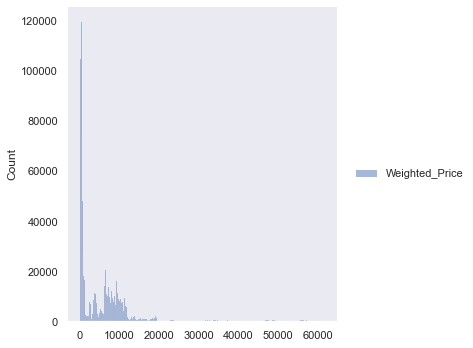

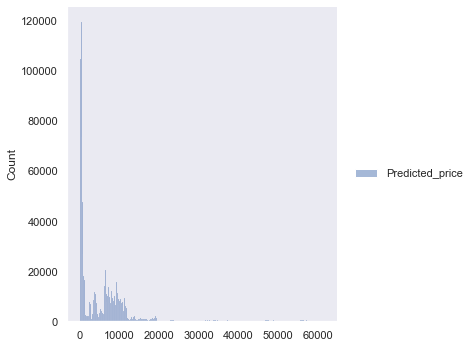

In [109]:
# Plot dos valores reais x valores previstos

# Extrai as previsões
pred_results_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

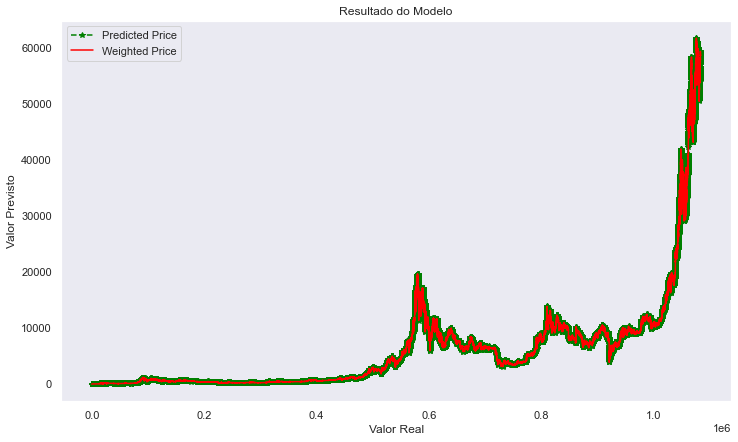

In [110]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Resultado do Modelo')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.legend()

>  Usaremos o modelo_v1

## Previsões em Tempo Real

In [111]:
# Novos dados
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [112]:
# Prepara o dataframe do Pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [113]:
# Visualiza
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [115]:
# Converte o dataframe do Pandas para dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados) 

C:\Users\henri\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\henri\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [116]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [117]:
# Visualiza
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [118]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [119]:
# Visualiza os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [120]:
# Normaliza os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [121]:
# Previsões com os novos dados
previsoes = modelo_v1.transform(df_assembled_scaled)

In [122]:
# Imprime as previsões
pred_data = previsoes.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|20538.489456850693|
|  21612.4797757362|
+------------------+



In [123]:
# Encerra a sessão Spark
spark_session.stop()